In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import shap
import seaborn as sns
import plotly.express as px
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
import calendar
import requests
from sklearn.compose import ColumnTransformer
import json

In [33]:
from utils.weather_utils import query_temperatures, count_temperatures_above_threshold, create_country_coordinates_dict, create_dates

In [2]:
directory = '../data/raw/'

top_countries_valid_death = pd.read_csv('../data/processed/country_focus.csv')
top_countries_valid_death.head()

,Unnamed: 0,Dis No,Year,Seq,Glide,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,...,"Reconstruction Costs, Adjusted ('000 US$)",Insured Damages ('000 US$),"Insured Damages, Adjusted ('000 US$)",Total Damages ('000 US$),"Total Damages, Adjusted ('000 US$)",CPI,Adm Level,Admin1 Code,Admin2 Code,Geo Locations
0,59,2003-0391-AUT,2003,391,NaN,Natural,Meteorological,Extreme temperature,Heat wave,NaN,...,NaN,NaN,NaN,280000.0,445445.0,62.858460,1,478;479;480;481;482;483;484;485;486,NaN,"Burgenland, Karnten, Niederosterreich, Oberost..."
1,71,2003-0391-BEL,2003,391,NaN,Natural,Meteorological,Extreme temperature,Heat wave,NaN,...,NaN,NaN,NaN,NaN,NaN,62.858460,1,600;601;602,NaN,Region de Bruxelles-Capitale / Brussels Hoofds...
2,117,2004-0333-ALB,2004,333,NaN,Natural,Meteorological,Extreme temperature,Heat wave,NaN,...,NaN,NaN,NaN,NaN,NaN,64.541329,2,NaN,3819,Durres (Adm2).
3,196,2003-0391-DEU,2003,391,NaN,Natural,Meteorological,Extreme temperature,Heat wave,NaN,...,NaN,10000.0,15909.0,1650000.0,2624945.0,62.858460,1,1308;1309;1310;1311;1312;1313;1314;1315;1316;1...,NaN,"Baden-Wuerttemberg, Bayern, Berlin, Brandenbur..."
4,197,2003-0391-ESP,2003,391,NaN,Natural,Meteorological,Extreme temperature,Heat wave,NaN,...,NaN,NaN,NaN,880000.0,1399971.0,62.858460,1,2716,NaN,Andalucía (Adm1).


# Process data and add Eurostat features

In [3]:
# Define a custom transformer to process Eurostat features
class EurostatFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, files, two_to_three_iso):
        self.files = files
        self.two_to_three_iso = two_to_three_iso

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        new_features = X[['ISO']].copy()

        for file in self.files:
            df_health = pd.read_csv(directory + file + '.csv')
            
            if file == 'disabled':
                df_health = df_health[df_health['assist'] == 'TOTAL']

            df_health['geo'] = df_health['geo'].map(self.two_to_three_iso)
            df_health_2022 = df_health[df_health['TIME_PERIOD'] == df_health['TIME_PERIOD'].max()]
            df_filtered = df_health_2022[['geo', 'OBS_VALUE']]
            df_filtered.columns = ['ISO', file]
            new_features = pd.merge(new_features, df_filtered, how='left', on='ISO')
        
        new_features = new_features.drop_duplicates(keep='first')
        return pd.merge(X, new_features, how='left', on='ISO')


# Custom transformer to find non-constant columns
class NonConstantColumnSelector(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        result = []
        for column in X.columns:
            unique_values = X[column].nunique()

            if unique_values > 1:
                result.append(column)
        
        return X[result]

# Custom transformer to remove columns with all NA values
class RemoveColumnsWithAllNA(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.columns_to_keep = X.columns[X.notna().any()]
        return self

    def transform(self, X):
        return X[self.columns_to_keep]

class CalculateDuration(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_copy = X.copy()

        mask = X_copy['Start Day'].notna() & X_copy['End Day'].notna()

        X_copy['Start Date'] = pd.to_datetime(dict(year=X_copy['Start Year'], month=X_copy['Start Month'], day=X_copy['Start Day']))
        X_copy['End Date'] = pd.to_datetime(dict(year=X_copy['End Year'], month=X_copy['End Month'], day=X_copy['End Day']))
        X_copy['Duration'] = X_copy['End Date'] - X_copy['Start Date']
        
        X_copy['Duration'] = X_copy['Duration'].apply(lambda x: x.days if not pd.isnull(x) else np.nan)

        return X_copy
    
# Create a FunctionTransformer for filtering
filter_continent = FunctionTransformer(lambda df: df[df['Continent'] == 'Europe'], validate=False)

remove_na_cpi = FunctionTransformer(lambda df: df.dropna(subset=['CPI']), validate=False)

# Define the files and ISO code mapping function
files = ['poverty', 'housing_deprive', 'forest', 'elder', 'population', 'gdp',
         'unemployment', 'child_population', 'disabled']

file_path = directory +"two_to_three_iso.json"
with open(file_path, 'r') as json_file:
    two_to_three_iso = json.load(json_file)
    
# Create a Pipeline
pipeline = Pipeline(steps=[
    ('continent_selector', filter_continent),
    ('remove_na_cpi', remove_na_cpi),
    ('remove_na_col', RemoveColumnsWithAllNA()),
    ('calculate_duration', CalculateDuration()),
    ('non_constant_col_selector', NonConstantColumnSelector()),
    ('eurostat_features', EurostatFeatureExtractor(files=files, two_to_three_iso=two_to_three_iso))
])

# Transform the DataFrame using the Pipeline and return the transformed DataFrame
transformed_df = pipeline.fit_transform(top_countries_valid_death)

# Add weather

In [21]:
# Create a custom transformer
class AddWeatherFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, capitals, two_to_three_iso, relevant_iso, threshold):
        self.capitals = capitals
        self.two_to_three_iso = two_to_three_iso
        self.relevant_iso = relevant_iso
        self.threshold = threshold

    def fit(self, X, y=None):
        self.country_coordinates_dict = create_country_coordinates_dict(self.capitals, self.two_to_three_iso, self.relevant_iso)
        return self

    def transform(self, X):
        dfs = X.copy()
        dfs['Start_Date'], dfs['End_Date'] = zip(*dfs.apply(create_dates, axis=1))
        
        for index, row in dfs.iterrows():
            start_date = row['Start_Date']
            end_date = row['End_Date']

            code = row['ISO']
            if code in self.country_coordinates_dict:
                lat = self.country_coordinates_dict[code]['CapitalLatitude']
                lon = self.country_coordinates_dict[code]['CapitalLongitude']

                temperatures = query_temperatures(lat, lon, start_date, end_date)
                above_threshold_count = count_temperatures_above_threshold(temperatures, self.threshold)
                max_temperature = max(temperatures) if temperatures else None

                dfs.loc[index, 'Days_over_30'] = above_threshold_count
                dfs.loc[index, 'Max_temp'] = max_temperature
            else:
                print(f"Data missing for ISO code: {code}")
        
        return dfs

# Define capitals, two_to_three_iso, relevant_iso

file_path = directory +"country_capitals.json"
with open(file_path, 'r') as json_file:
    capitals = json.load(json_file)
    
relevant_iso = list(transformed_df.ISO.unique())
threshold = 30

# Create the pipeline-like process using custom transformer
weather_pipeline = AddWeatherFeatures(capitals, two_to_three_iso, relevant_iso, threshold)

# Apply the pipeline to your data
transformed_df = weather_pipeline.fit_transform(transformed_df)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [24]:
def model_ad_hoc_prep(df):
    
    copy = dfs[~dfs['Max_temp'].isna()]
    copy = copy[~copy['child_population'].isna()]
    
    copy['month_length'] = copy['End Month'] - copy['Start Month']
    
#     processed_folder = '../data/processed/'
#     copy.to_csv(processed_folder + 'processed.csv')

    return copy

In [25]:
df_model = model_ad_hoc_prep(transformed_df)

# Modelling

In [26]:
features = ['Year', 'Start Month', 'month_length', 'Country',    
  #  'Duration',
           'Max_temp',
          'Days_over_30',
            'Region', 
          #  'Continent'
            'CPI',
           ] + files

df = df_model[features]

columns_to_encode = ['Region','Country']

# Get dummies for the specified columns
dummies = pd.get_dummies(df[columns_to_encode], columns=columns_to_encode, prefix=columns_to_encode)

In [27]:
X = pd.concat([df, dummies], axis=1).drop(columns_to_encode, axis=1)
y = df_model['Total Deaths'] #/merged_df['illness']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, random_state=42)


In [28]:
# Print the shapes of X_train, X_test, y_train, y_test
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Fit the Random Forest regression model
rf_model = RandomForestRegressor(n_estimators=400)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

y_pred_train = rf_model.predict(X_train)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)



X_train shape: (28, 27)
X_test shape: (13, 27)
y_train shape: (28,)
y_test shape: (13,)
Mean Squared Error (MSE): 12442838.143156251
Root Mean Squared Error (RMSE): 3527.440735598013
Mean Absolute Error (MAE): 2320.1301923076926
R-squared (R2): 0.5566406026210561


In [29]:
image_folder = '../images/'

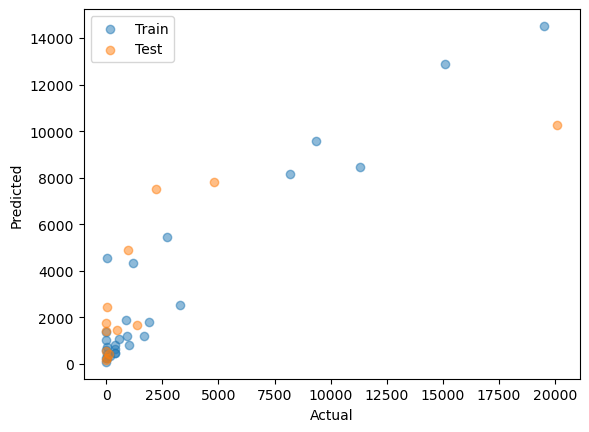

In [30]:
plt.scatter(y_train, y_pred_train, alpha=0.5, label='Train')
plt.scatter(y_test, y_pred, alpha=0.5, label='Test')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()  # Add legend

plt.savefig(image_folder + 'predicted_actual.png')  # Replace with the desired image file format

plt.show()

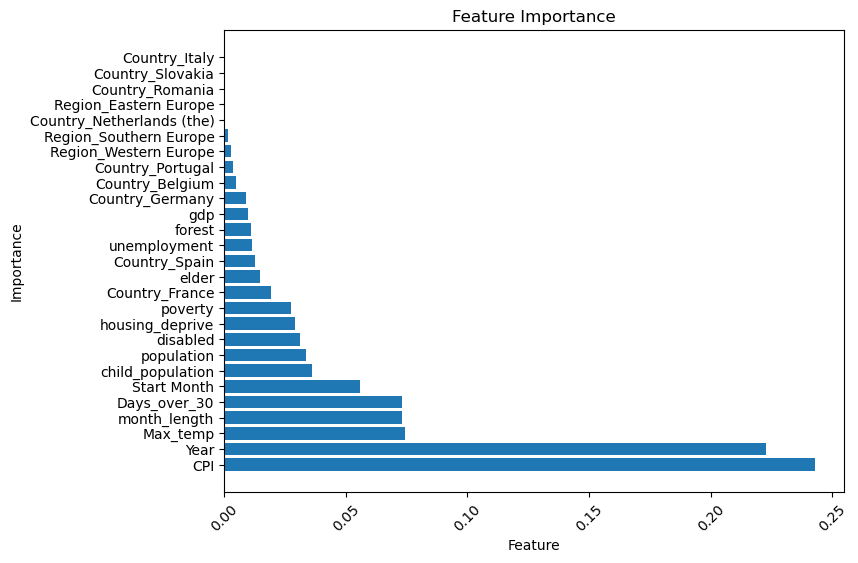

In [31]:
# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame with feature names and importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the features by importance
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45)

plt.savefig(image_folder + 'feature_importance.png')  # Replace with the desired image file format

plt.show()

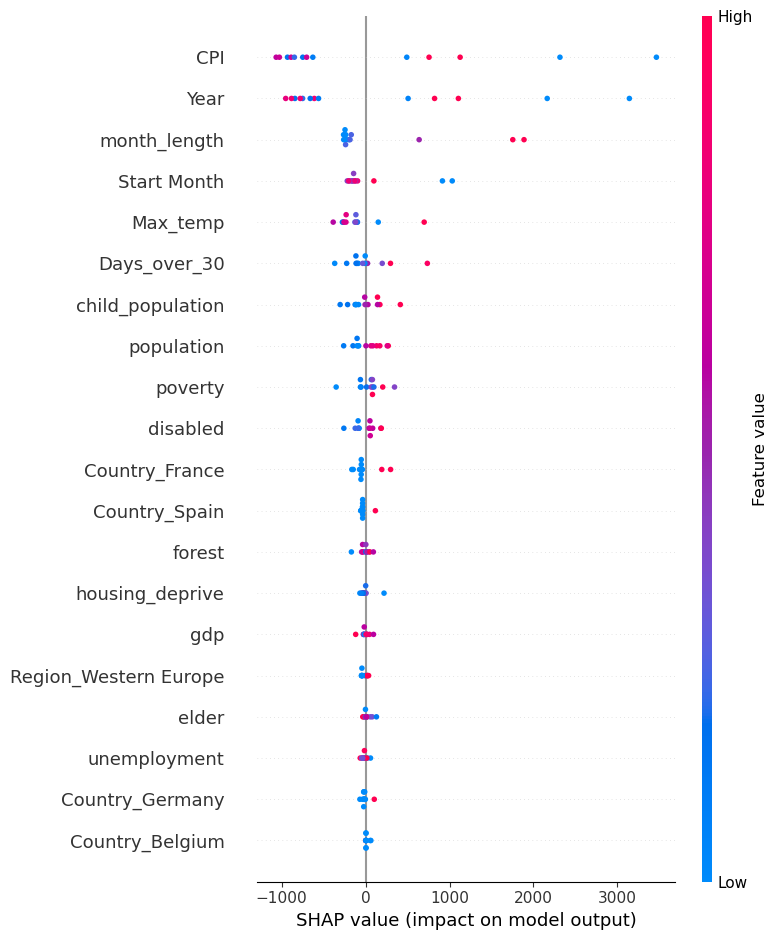

<Figure size 640x480 with 0 Axes>

In [32]:
# Calculate SHAP values
explainer = shap.Explainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Visualize SHAP values (e.g., summary plot)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

plt.savefig(image_folder + 'shap_summary_plot.png')